In [5]:
def generate_continuous_plot_data (price_result, market_price, nominal=True):
    import numpy as np
    import pandas as pd
    
    '''
    price_result: one balance strategy only
    '''
    price_df_list = market_price
    
    plot_data_list = []
    
    # 1. Get Nominal Price Transaction Records
    trans_date_df = pd.DataFrame([tmp['Date']for tmp in price_result], columns = ['Date']) 
    # ^ Action dates in the five years
    trans_df_list = []

    for market_num in range(3): # nominal_df_list[0-2] for three assets
        asset_df = pd.DataFrame([tmp['Record'][market_num] for tmp in price_result]) 
        # ^ Get the asset weightage at each time
        result_df = pd.concat([trans_date_df, asset_df], axis=1)
        result_df.rename(columns={'0':'Date'}, inplace=True)
        trans_df_list.append(result_df)
    
    for market_num in range(3):
        tmp_trans_df = trans_df_list[market_num]
        trans_date = tmp_trans_df['Date']
        start_date = list(trans_date)[0]
        end_date = list(price_df_list[0]['Date'])[-1]

        history_df = price_df_list[market_num]
        all_price_date = history_df['Date'][(history_df['Date']>=start_date) & (history_df['Date']<= end_date)]
        plot_data = []
        number = 0
        net_value = 0
        price = 0
        for date in all_price_date:
            if (trans_date == date).any(): # If rebalanced at that day:
                number = tmp_trans_df['Number'][tmp_trans_df['Date']==date].values[0]
                net_value = tmp_trans_df['Net Value'][tmp_trans_df['Date']==date].values[0]
                price = tmp_trans_df['Price'][tmp_trans_df['Date']==date].values[0]
            else:
                if nominal:
                    price = history_df['Price'][history_df['Date']==date].values[0]
                else:
                    price = history_df['Actual Price'][history_df['Date']==date].values[0]

                net_value = number*price
            plot_data.append({
                "Date": date,
                "Number": number,
                "Price": price,
                "Net Value": net_value
            })
        plot_data_list.append(plot_data)
        
    return trans_df_list, plot_data_list

In [6]:
def generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.gridspec import GridSpec
    from CSVUtils import csv2df

    DIR = "./from github/Stock-Trading-Environment/data"
    file_names = ["^BVSP", "^TWII", "^IXIC"]
    source_list = ["yahoo", "yahoo", "yahoo"] # for plotting price data

    nominal_labels = ["high risk-^BVSP_nominal", "mid risk-^TWII_nominal", "low risk-^IXIC"]
    actual_labels = ["high risk-^BVSP_actual", "mid risk-^TWII_actual", "low rick-^IXIC"]


    plt.rcParams['figure.facecolor'] = 'white'
    fig=plt.figure(figsize=(40,25))
    axs = []
    gs=GridSpec(5,1) # 5 rows, 1 columns
    axs.append(fig.add_subplot(gs[0,0])) # First row, first column
    axs.append(fig.add_subplot(gs[1,0])) # First row, second column
    axs.append(fig.add_subplot(gs[2,0])) # First row, third column
    axs.append(fig.add_subplot(gs[3:,:])) # Second row, span all columns



    for i, plot_data in enumerate(nominal_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

        axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
                    color="C0", label = nominal_labels[i]+"_Log Market Value")
        axs[i].bar(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
                   width=2, color="C0")
        axs[i].plot(nominal_trans_df_list[i]['Date'], np.log(nominal_trans_df_list[i]['Net Value']/nominal_trans_df_list[i]['Net Value'][0]), 
                    linestyle='--', color="C0", label = nominal_labels[i]+"_Log Book Value")

        axs[i].axhline(y=0, color = "grey", linestyle='--')
        axs[i].legend()
        axs[i].set_title('Portfolio Weights')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Market Value (US$)')


    for i, plot_data in enumerate(actual_plot_data_list):
        plot_data = pd.DataFrame(plot_data)

        axs[i].plot(plot_data['Date'], np.log(plot_data['Net Value']/plot_data['Net Value'][0]), 
                    color="orange", label = actual_labels[i]+"_Log Market Value")
        axs[i].bar(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/actual_trans_df_list[i]['Net Value'][0]), 
                   width=2, color="orange")

        axs[i].plot(actual_trans_df_list[i]['Date'], np.log(actual_trans_df_list[i]['Net Value']/actual_trans_df_list[i]['Net Value'][0]), 
                    linestyle='--', color="orange", label = actual_labels[i]+"_Log Book Value")
        axs[i].plot(price_df_list[i]['Date'], np.log(price_df_list[i]['Cum FX Change']),
                    color="green", linestyle='--', label = nominal_labels[i]+"_Log FX Change")


        axs[i].axhline(y=0, color = "grey", linestyle='--')
    #     axs[i].set_ylim((0, 300000))
        axs[i].set_title('Log Portfolio Value')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Log Value')



    for i in range(2,-1,-1): # Inverse: Low-Mid-High
        df = csv2df(DIR, file_names[i]+".csv",source = source_list[i])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[(df['Date']>=pd.to_datetime("2015-01-01"))&(df['Date']<=pd.to_datetime("2019-12-31"))].reset_index(drop=True)

        j = 0
        init_price = df['Price'][j]
        while np.isnan(init_price):
            j+=1
            init_price = df['Price'][j]
        y = np.log(df['Price'][j:] / init_price)
        x = df['Date'][j:]
        axs[3].plot(x,y,label = nominal_labels[i])
        axs[i].plot(x,y, color = "pink", linestyle='--', label = nominal_labels[i]+"_Log Nominal Price")
        axs[i].legend()

    axs[3].axhline(y=0, color = "grey", linestyle='--')
    # axs[3].set_ylim((-1,1))
    axs[3].legend()
    axs[3].set_title('Log Market Price')
    axs[3].set_xlabel('Date')
    axs[3].set_ylabel('log(Market Price)')
    plt.show()

In [7]:
def plot_rebalance_record(nominal_price_result, actual_price_result, market_price):
    '''
    rebalance_record = [nominal_price_result, actual_price_result];
    nominal_price_resul[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], REGARDLESS of Commission Cost and FX Change;
    actual_price_result[0-3]: The Transaction Records for evenly rebalancing the portfolio for [1 year, 6 months, 3 months, 1 month], CONSIDERING of Commission Cost and FX Change;
    
    price_df_list[0-2]: The History data for three indexes [^BVSP, ^TWII, ^IXIC] within a given range, with:
    Nominal Price['Price'], and Actual Price ['Actual Price'], where the Cummulative FX Change ['Cum FX Change'] is considered
    '''
    
    nominal_trans_df_list, nominal_plot_data_list = generate_continuous_plot_data(nominal_price_result, market_price, nominal=True)
    actual_trans_df_list, actual_plot_data_list = generate_continuous_plot_data(actual_price_result, market_price, nominal=False)

    generate_graph(nominal_plot_data_list, actual_plot_data_list, nominal_trans_df_list, actual_trans_df_list)

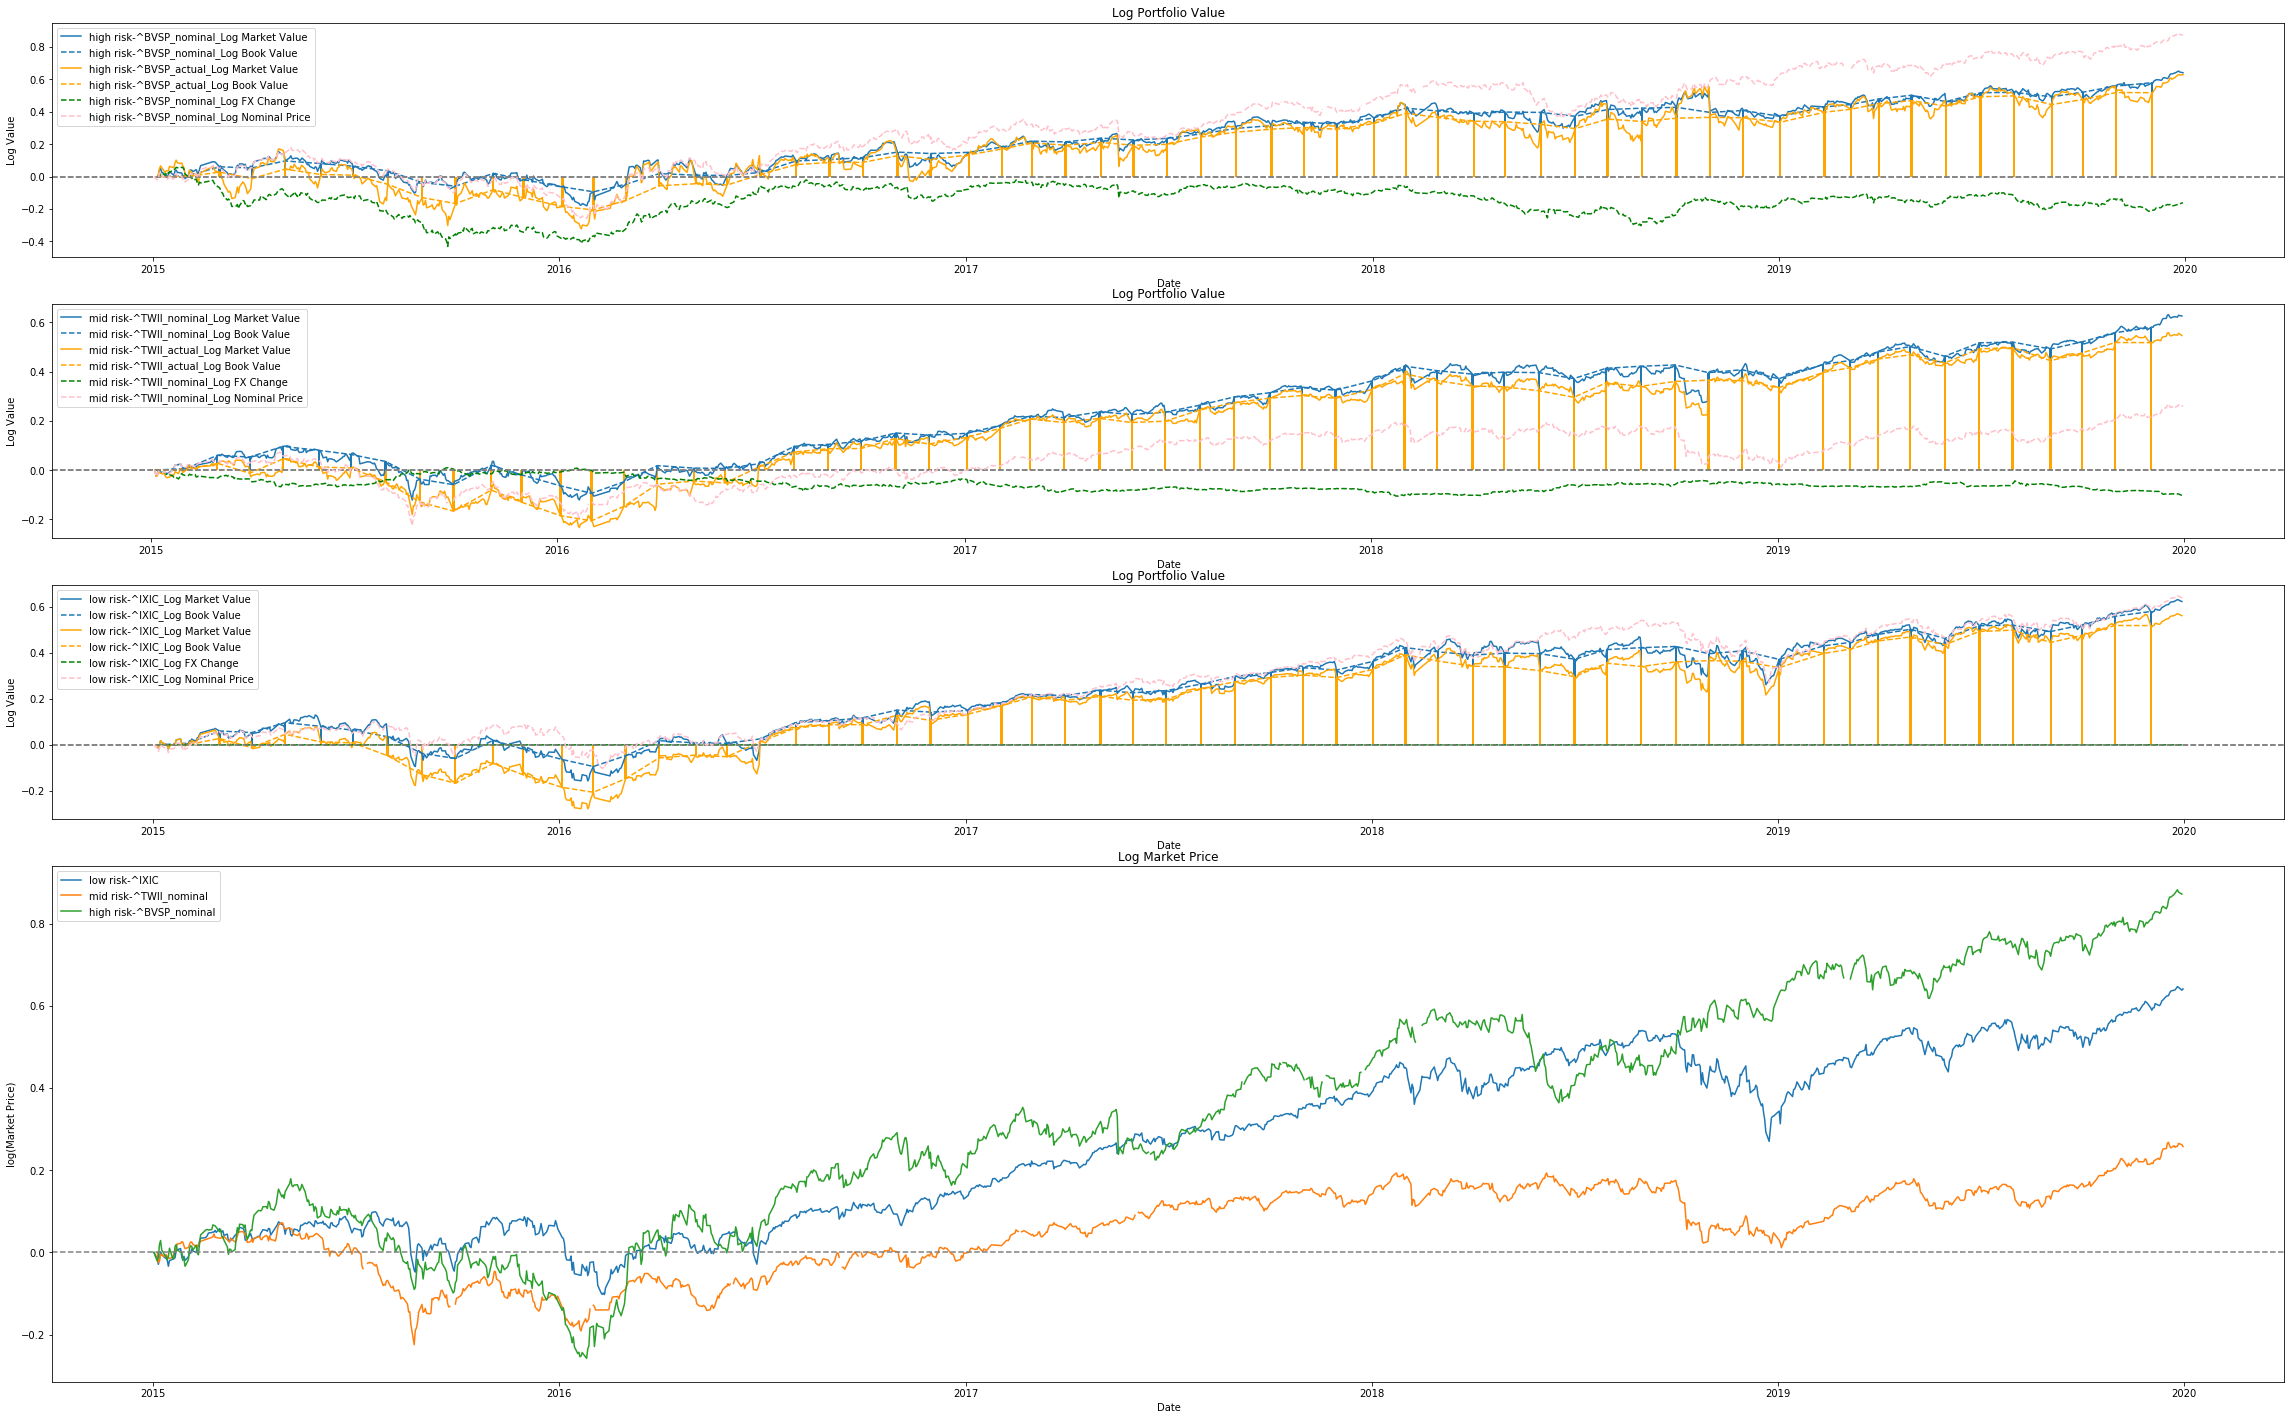

In [8]:
import pickle

tmp = pickle.load(open("0306-currency adjusted rebalance record.out", "rb"))
nominal_price_result = tmp[0][3] # Six Months
actual_price_result = tmp[1][3]
price_df_list = pickle.load(open("0306-adjusted market prices.out", "rb"))

plot_rebalance_record(nominal_price_result, actual_price_result, price_df_list)

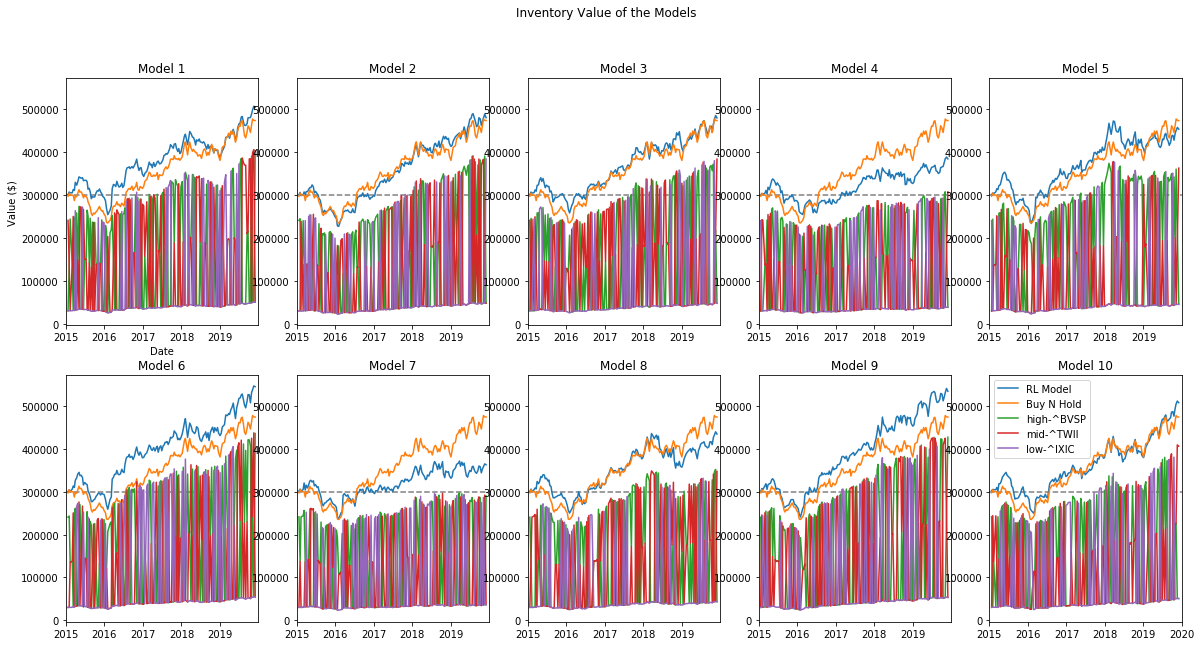

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path

output_dir = "./from github/Stock-Trading-Environment/output/300"
axx = plt.figure(figsize=(20,10))
plt.suptitle("Inventory Value of the Models")
plt.rcParams['figure.facecolor'] = 'white'
# legend_list = ['S&P 500', 'Germany Dax', 'Hang Seng', 'CASH']
labels = ["high-^BVSP", "mid-^TWII", "low-^IXIC"]
for i in range(10):
    try:
        if i == 0:
            ax0 = plt.subplot(2, 5, 1)
            plt.xlabel("Date")
            plt.ylabel("Value ($)")
            ax = ax0
        else:
            ax = plt.subplot(2, 5, i+1, sharex=ax0, sharey = ax0)
        
        record = pickle.load(open(path.join(output_dir,"BRZ_TW_NASDAQ-MultiRewardWithLeakage-7d_detailed-ModelNo-100-"+str(i)+".out"), "rb"))
        df = pd.DataFrame(record)
#         plt.axhline(y=0, color = "grey", linestyle='--')
        plt.axhline(y=300000, color = "grey", linestyle='--')
        plt.xlim((pd.Timestamp('2015-01-01'),pd.Timestamp('2019-12-31')))
        ax.set_xticks([pd.Timestamp('2015-01-01'), pd.Timestamp('2016-01-01'), 
                       pd.Timestamp('2017-01-01'), pd.Timestamp('2018-01-01'),
                       pd.Timestamp('2019-01-01'), pd.Timestamp('2020-01-01')])
        plt.plot(df['date'], df['net_worth'], label="RL Model")
        plt.plot(df['date'], df['buyNhold_balance'], label="Buy N Hold")
        
        for j in range(3):
            plt.plot(df['date'], [tmp[j] for tmp in df['inventory']], label=labels[j])
#             first_price = df['actual_price'][0][j]
#             plt.plot(df['date'], [tmp[j]/first_price*300000 for tmp in df['actual_price']])
        plt.title("Model "+str(i+1))
    except Exception as e:
        print(e)
plt.legend()

In [12]:
record = pickle.load(open(path.join(output_dir,"BRZ_TW_NASDAQ-MultiRewardWithLeakage-7d_detailed-ModelNo-100-0.out"), "rb"))
df = pd.DataFrame(record)

In [28]:
df

,date,actual_price,action,inventory,shares_held,net_worth,net_worth_delta,buyNhold_balance,buyNhold_delta,actual_profit,progress,testNo,cate,tuple
0,2015-01-22,"[48914.07773006017, 9239.599686626838, 4676.49...","[0.0, 0.25269178, 0.0, 0.0]","[30222.17130264781, 241423.3605392797, 30222.1...","[0.6178624376694475, 26.129201342857932, 6.462...",301867.703145,1867.703145,297441.945932,-2558.054068,4425.757213,-0.730803,0,3,"(0, 3)"
1,2015-02-02,"[49225.84112214274, 9432.03965044065, 4760.653...","[0.07478706, 0.0, 1.0, 0.0]","[138164.7584790552, 138434.63930082537, 30763....","[2.8067526187359753, 14.677062908059117, 6.461...",307362.650958,5494.947813,304873.784848,7431.838916,2488.866110,0.739414,1,2,"(1, 2)"
2,2015-02-11,"[48749.40648820274, 9444.093664093778, 4710.13...","[1.0, 0.7060263, 1.0, 0.0]","[244431.2008897094, 30587.589414416307, 30587....","[5.0140343954517945, 3.2388062319531628, 6.493...",305606.003013,-1756.647945,300600.322251,-4273.462597,5005.680762,0.410922,2,2,"(2, 2)"
3,2015-03-03,"[48615.759076379494, 9463.37285880479, 4840.31...","[0.0, 0.0, 0.7141873, 0.45217443]","[137629.66194488318, 137362.38002317035, 30584...","[2.8309680761881197, 14.515160933912414, 6.318...",305576.411289,-29.591724,300237.572093,-362.750158,5338.839197,0.079037,3,0,"(3, 0)"
4,2015-03-12,"[50464.93397533225, 9601.332849890618, 4951.46...","[0.0, 0.7903145, 0.0, 0.0]","[31351.622360094672, 250534.53279993273, 31351...","[0.6212555905734396, 26.093724352321242, 6.331...",313237.615353,7661.204064,299980.884993,-256.687100,13256.730360,-29.967112,4,1,"(4, 1)"
5,2015-03-23,"[48592.202397779816, 9611.037186616772, 4855.4...","[0.39843175, 0.0, 0.0, 0.0]","[248827.9994392128, 31171.95319740982, 31170.8...","[5.120739278337007, 3.2433495565719284, 6.4197...",311170.835619,-2066.779734,287486.496779,-12494.388214,23684.338840,0.165350,5,2,"(5, 2)"
6,2015-04-01,"[52147.082801524695, 9755.853829987438, 5009.3...","[0.0, 0.3277173, 0.0, 1.0]","[33083.179557854135, 33079.57797184219, 264084...","[0.6344205232682132, 3.390741451062186, 52.718...",330247.290034,19076.454415,297989.723962,10503.227183,32257.566072,1.816169,6,3,"(6, 3)"
7,2015-04-14,"[52873.402675541765, 9538.451469339361, 4897.4...","[1.0, 0.0, 0.0, 0.40357313]","[258695.17801094134, 32407.22683364404, 32407....","[4.892728005391051, 3.397535432015841, 6.61719...",323509.793993,-6737.496041,296322.145864,-1667.578098,27187.648128,4.042112,7,1,"(7, 1)"
8,2015-04-24,"[54222.12768884132, 9636.661475248868, 5004.41...","[0.0, 0.0, 1.0, 0.7806915]","[149017.59520032996, 148727.08514168853, 33115...","[2.7482801127886605, 15.433465783112158, 6.617...",330859.701498,7349.907505,304369.286702,8047.140838,26490.414795,0.913367,8,3,"(8, 3)"
9,2015-05-06,"[56674.936781532575, 9961.570484339365, 5060.0...","[1.0, 1.0, 0.0, 1.0]","[274090.0309664623, 34298.30189302984, 34296.2...","[4.836177092230547, 3.4430617086884414, 6.7779...",342684.597422,11824.895924,312750.218134,8380.931432,29934.379288,1.410880,9,0,"(9, 0)"


In [23]:
cate_list = []
for tmp_cate in set(df['cate']):
    cate_list.append(df[df['cate']==tmp_cate][['date', 'net_worth']])

In [27]:

df['tuple'] = list(zip(df['testNo'], df['cate']))

In [29]:
set(df['tuple'])

{(0, 3),
 (1, 2),
 (2, 2),
 (3, 0),
 (4, 1),
 (5, 2),
 (6, 3),
 (7, 1),
 (8, 3),
 (9, 0),
 (10, 3),
 (11, 0),
 (12, 0),
 (13, 3),
 (14, 3),
 (15, 0),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 0),
 (20, 1),
 (21, 0),
 (22, 1),
 (23, 3),
 (24, 3),
 (25, 3),
 (26, 1),
 (27, 3),
 (28, 1),
 (29, 2),
 (30, 1),
 (31, 1),
 (32, 0),
 (33, 1),
 (34, 0),
 (35, 2),
 (36, 3),
 (37, 2),
 (38, 2),
 (39, 3),
 (40, 3),
 (41, 1),
 (42, 3),
 (43, 0),
 (44, 1),
 (45, 2),
 (46, 1),
 (47, 2),
 (48, 2),
 (49, 2),
 (50, 2),
 (51, 0),
 (52, 3),
 (53, 0),
 (54, 2),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 0),
 (59, 2),
 (60, 1),
 (61, 1),
 (62, 2),
 (63, 1),
 (64, 3),
 (65, 1),
 (66, 2),
 (67, 0),
 (68, 1),
 (69, 2),
 (70, 0),
 (71, 3),
 (72, 3),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 3),
 (77, 0),
 (78, 2),
 (79, 0),
 (80, 3),
 (81, 3),
 (82, 1),
 (83, 2),
 (84, 0),
 (85, 3),
 (86, 0),
 (87, 0),
 (88, 3),
 (89, 2),
 (90, 0),
 (91, 0),
 (92, 3),
 (93, 2),
 (94, 3),
 (95, 0),
 (96, 1),
 (97, 2),
 (98, 0),
 (99, 1),
 (100, 3),